In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import matplotlib.pyplot as plt
import re

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
sample_df = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

# Description of problem and data

In [4]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
display(train_df.loc[train_df['target'] == 1, 'text'].head(3).tolist())
display(train_df.loc[train_df['target'] == 0, 'text'].head(3).tolist())

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"]

["What's up man?", 'I love fruits', 'Summer is lovely']

# Exporatory Data Analysis

There are slightly more tweets related to a non-disaster than tweets related to a disaster. Something to keep in mind for weights to use in the models. On average tweets related to a disaster also are longer in text length. 

The preprocessing of text is pretty standard. It consists of converting all text to the same case, removing puncuation and unnecessary characters, tokenization, removing stop words, and joining the words back together into cohesive text.

I elected to use TF-IDF because it puts more of an emphasis on unique words in a tweet. I also had to use Vectorizer for LSTM because of the dependency on the sequence of text.

In [6]:
train_df['text_length'] = train_df['text'].str.len()
length_stats_0 = train_df.loc[train_df['target'] == 0, 'text_length'].describe()
length_stats_1 = train_df.loc[train_df['target'] == 1, 'text_length'].describe()

display("Text length for 0", length_stats_0)
display("Text length stats for 1", length_stats_1)

'Text length for 0'

count    4342.000000
mean       95.706817
std        35.885924
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       157.000000
Name: text_length, dtype: float64

'Text length stats for 1'

count    3271.000000
mean      108.113421
std        29.309854
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       151.000000
Name: text_length, dtype: float64

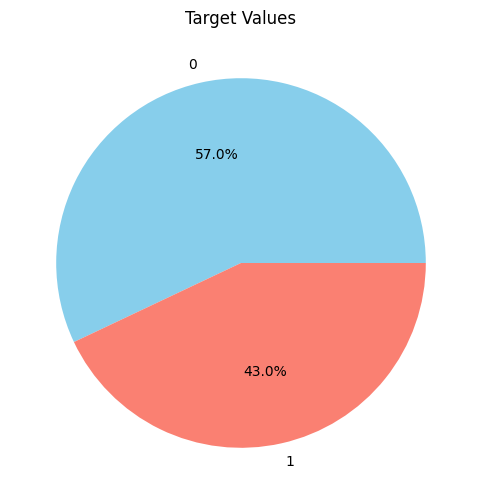

In [7]:
target_counts = train_df['target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title("Target Values")
plt.show()

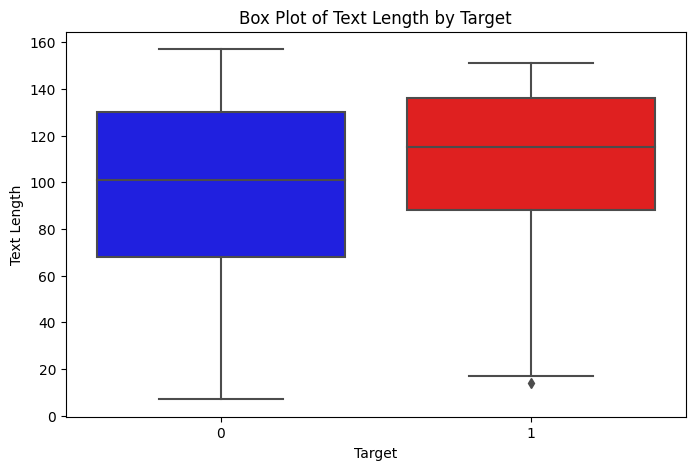

In [8]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x=train_df["target"], y=train_df["text_length"], palette=["blue", "red"])

plt.xlabel("Target")
plt.ylabel("Text Length")
plt.title("Box Plot of Text Length by Target")

plt.show()

In [9]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    words = word_tokenize(text)
    words = [w for w in words if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['target'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_df['text'])

print("\nVectorizerTrain shape:", X_train.shape)
print("\nVectorizerTest shape:", X_test.shape)
print("\nValidation set shape:", X_val.shape)


VectorizerTrain shape: (6090, 17351)

VectorizerTest shape: (3263, 17351)

Validation set shape: (1523, 17351)


# Model Architecture

I started with non neural net models to have variety and get a baseline. LogisticRegression, RandomForest, and GradientBoosting also differ in nature to provide unique results. For neural net models I also had a baseline with shallow depth and less layers then worked up to more advanced models. The next step was neural net models using CNN then finally LSTM.

In [11]:
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
}

param_grids = {
    'LogisticRegression': {
        'C': [0.5, 1, 2],
        'solver': ['lbfgs'],
        'max_iter': [100, 200],
        'penalty': ['l2'],
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'class_weight': ['balanced'],
    },
    'GradientBoosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.5],
    },
}

model_results_linear = {}

for model_name in models:
    print(f"\nRunning {model_name}...")
    
    grid_search = GridSearchCV(estimator=models[model_name], param_grid=param_grids[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred_train = best_model.predict(X_train)
    y_pred_val = best_model.predict(X_val)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)

    train_precision = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    val_precision = precision_score(y_val, y_pred_val, average='weighted', zero_division=0)

    train_recall = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    val_recall = recall_score(y_val, y_pred_val, average='weighted', zero_division=0)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    val_f1 = f1_score(y_val, y_pred_val, average='weighted', zero_division=0)

    model_results_linear[model_name] = {
        "best_params": grid_search.best_params_,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "train_precision": train_precision,
        "val_precision": val_precision,
        "train_recall": train_recall,
        "val_recall": val_recall,
        "train_f1": train_f1,
        "val_f1": val_f1,
        "predictions": best_model.predict(X_test)
    }


Running LogisticRegression...

Running RandomForest...

Running GradientBoosting...


In [12]:
for model_name, result in model_results_linear.items():
    print(f"\n{model_name}:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Train Accuracy: {result['train_accuracy']:.4f}, Validation Accuracy: {result['val_accuracy']:.4f}")
    print(f"Train Precision: {result['train_precision']:.4f}, Validation Precision: {result['val_precision']:.4f}")
    print(f"Train Recall: {result['train_recall']:.4f}, Validation Recall: {result['val_recall']:.4f}")
    print(f"Train F1-score: {result['train_f1']:.4f}, Validation F1-score: {result['val_f1']:.4f}")


LogisticRegression:
Best Parameters: {'C': 2, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Train Accuracy: 0.9279, Validation Accuracy: 0.7984
Train Precision: 0.9307, Validation Precision: 0.7978
Train Recall: 0.9279, Validation Recall: 0.7984
Train F1-score: 0.9273, Validation F1-score: 0.7970

RandomForest:
Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 200}
Train Accuracy: 0.9972, Validation Accuracy: 0.7840
Train Precision: 0.9972, Validation Precision: 0.7892
Train Recall: 0.9972, Validation Recall: 0.7840
Train F1-score: 0.9972, Validation F1-score: 0.7785

GradientBoosting:
Best Parameters: {'learning_rate': 0.5, 'n_estimators': 50}
Train Accuracy: 0.8391, Validation Accuracy: 0.7722
Train Precision: 0.8510, Validation Precision: 0.7756
Train Recall: 0.8391, Validation Recall: 0.7722
Train F1-score: 0.8347, Validation F1-score: 0.7668


In [13]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['text']).toarray()
X_test = vectorizer.transform(test_df['text']).toarray()
MAX_FEATS = X_train.shape[1]

X_train, X_val, y_train, y_val = train_test_split(X_train, train_df['target'], test_size=0.2, random_state=42)

print("Data shapes:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

def BaselineDenseModel():
    model = Sequential([
        Dense(256, input_dim=MAX_FEATS, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def RegularizedDenseModel():
    model = Sequential([
        Dense(256, input_dim=MAX_FEATS, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def RegularizedDropoutDenseModel():
    model = Sequential([
        Dense(256, input_dim=MAX_FEATS, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.01)),
        Dropout(0.6),
        Dense(128, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def ModerateDeepDenseModel():
    model = Sequential([
        Dense(512, input_dim=MAX_FEATS, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def DeepDenseModel():
    model = Sequential([
        Dense(1024, input_dim=MAX_FEATS, activation='relu'),
        Dropout(0.6),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_and_evaluate(model_func):
    model = model_func()
    model.summary()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=callbacks
    )

    predictions = model.predict(X_test)
    predictions_binary = (predictions > 0.5).astype(int)

    arr_flattened = predictions_binary.flatten()
    num_ones = np.sum(arr_flattened == 1)
    num_zeros = np.sum(arr_flattened == 0)

    model_details = {
        "history": history.history,
        "predictions": predictions_binary,
        "num_ones": num_ones,
        "num_zeros": num_zeros,
        "model_summary": model.summary(),
    }

    return model_details

Data shapes:
Training: (6090, 20262)
Validation: (1523, 20262)


In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

def CNNModel():
    model = Sequential([
        Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_FEATS, 1)),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),

        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),

        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [17]:
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_lstm():
    MAX_WORDS = 20000
    MAX_LEN = 200
    
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(train_df['text'])
    
    X_train = tokenizer.texts_to_sequences(train_df['text'])
    X_test = tokenizer.texts_to_sequences(test_df['text'])
    
    X_train = pad_sequences(X_train, maxlen=MAX_LEN)
    X_test = pad_sequences(X_test, maxlen=MAX_LEN)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, train_df['target'], test_size=0.2, random_state=42)
    
    def LSTMModel():
        model = Sequential([
            Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
            
            Bidirectional(LSTM(128, return_sequences=True)),
            Dropout(0.5),
    
            LSTM(64, return_sequences=True),
            Dropout(0.4),
    
            LSTM(32),
            Dropout(0.3),
    
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    model = LSTMModel()

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping]
    )
    
    model.summary()
    
    predictions = model.predict(X_test)
    predictions_binary = (predictions > 0.5).astype(int)
    
    arr_flattened = predictions_binary.flatten()
    num_ones = np.sum(arr_flattened == 1)
    num_zeros = np.sum(arr_flattened == 0)
    
    model_details = {
        "history": history.history,
        "predictions": predictions_binary,
        "num_ones": num_ones,
        "num_zeros": num_zeros
    }
    
    return model_details

In [18]:
results = {}

print("\nTraining BaselineDenseModel:")
results["BaselineDenseModel"] = train_and_evaluate(BaselineDenseModel)

print("\nTraining RegularizedDenseModel:")
results["RegularizedDenseModel"] = train_and_evaluate(RegularizedDenseModel)

print("\nTraining RegularizedDropoutDenseModel:")
results["RegularizedDropoutDenseModel"] = train_and_evaluate(RegularizedDropoutDenseModel)

print("\nTraining ModerateDeepDenseModel:")
results["ModerateDeepDenseModel"] = train_and_evaluate(ModerateDeepDenseModel)

print("\nTraining DeepDenseModel:")
results["DeepDenseModel"] = train_and_evaluate(DeepDenseModel)

print("\nTraining CNN Model:")
results["CNNModel"] = train_and_evaluate(CNNModel)

print("\nTraining LSTM Model:")
results["LSTMModel"] = get_lstm()


Training BaselineDenseModel:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 256)                 │       5,187,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,220,353 (19.91 MB)

 Trainable params: 5,220,353 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6410 - loss: 0.6183 - val_accuracy: 0.7958 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9117 - loss: 0.2377 - val_accuracy: 0.7807 - val_loss: 0.5042 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9701 - loss: 0.0970 - val_accuracy: 0.7617 - val_loss: 0.6448 - learning_rate: 0.0010
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 256)                 │       5,187,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,661,061 (59.74 MB)

 Trainable params: 5,220,353 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,440,708 (39.83 MB)


Training RegularizedDenseModel:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 256)                 │       5,187,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,220,353 (19.91 MB)

 Trainable params: 5,220,353 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5687 - loss: 2.6586 - val_accuracy: 0.5804 - val_loss: 0.7706 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6243 - loss: 0.7616 - val_accuracy: 0.7183 - val_loss: 0.8052 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7488 - loss: 0.8188 - val_accuracy: 0.7807 - val_loss: 0.8523 - learning_rate: 0.0010
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 256)                 │       5,187,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,661,061 (59.74 MB)

 Trainable params: 5,220,353 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,440,708 (39.83 MB)


Training RegularizedDropoutDenseModel:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 256)                 │       5,187,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,220,353 (19.91 MB)

 Trainable params: 5,220,353 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5529 - loss: 3.4642 - val_accuracy: 0.5739 - val_loss: 1.1025 - learning_rate: 5.0000e-04
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5887 - loss: 0.9693 - val_accuracy: 0.6284 - val_loss: 0.7714 - learning_rate: 5.0000e-04
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6690 - loss: 0.7531 - val_accuracy: 0.7118 - val_loss: 0.7475 - learning_rate: 5.0000e-04
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 256)                 │       5,187,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,661,061 (59.74 MB)

 Trainable params: 5,220,353 (19.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,440,708 (39.83 MB)


Training ModerateDeepDenseModel:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 512)                 │      10,374,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,539,009 (40.20 MB)

 Trainable params: 10,539,009 (40.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6428 - loss: 0.6191 - val_accuracy: 0.7912 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8952 - loss: 0.2641 - val_accuracy: 0.7873 - val_loss: 0.4994 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9603 - loss: 0.1121 - val_accuracy: 0.7695 - val_loss: 0.6804 - learning_rate: 0.0010
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 512)                 │      10,374,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,617,029 (120.61 MB)

 Trainable params: 10,539,009 (40.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,078,020 (80.41 MB)


Training DeepDenseModel:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                     │ (None, 1024)                │      20,749,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,438,465 (81.78 MB)

 Trainable params: 21,438,465 (81.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6179 - loss: 0.6287 - val_accuracy: 0.7846 - val_loss: 0.4585 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8886 - loss: 0.2830 - val_accuracy: 0.7919 - val_loss: 0.4878 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9515 - loss: 0.1399 - val_accuracy: 0.7761 - val_loss: 0.6432 - learning_rate: 0.0010
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                     │ (None, 1024)                │      20,749,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,315,397 (245.34 MB)

 Trainable params: 21,438,465 (81.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,876,932 (163.56 MB)


Training CNN Model:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 20258, 128)          │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 10129, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 10129, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 10127, 64)           │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 5063, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 5063, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 5061, 32)            │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2530, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 2530, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 80960)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │      10,363,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,394,721 (39.65 MB)

 Trainable params: 10,394,721 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.6343 - loss: 0.6387 - val_accuracy: 0.7603 - val_loss: 0.5048 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.8115 - loss: 0.4165 - val_accuracy: 0.7689 - val_loss: 0.4937 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.8794 - loss: 0.2906 - val_accuracy: 0.7505 - val_loss: 0.5340 - learning_rate: 0.0010
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 20258, 128)          │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 10129, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 10129, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 10127, 64)           │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 5063, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 5063, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 5061, 32)            │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2530, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 2530, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 80960)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │      10,363,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,184,165 (118.96 MB)

 Trainable params: 10,394,721 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,789,444 (79.31 MB)


Training LSTM Model:
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.6465 - loss: 0.6148 - val_accuracy: 0.7912 - val_loss: 0.4523
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8995 - loss: 0.2765 - val_accuracy: 0.7584 - val_loss: 0.5918
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9698 - loss: 0.1003 - val_accuracy: 0.6717 - val_loss: 1.1316
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9853 - loss: 0.0508 - val_accuracy: 0.7492 - val_loss: 0.9525


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 200, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 200, 64)             │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 200, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,766,341 (33.44 MB)

 Trainable params: 2,922,113 (11.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,844,228 (22.29 MB)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


In [23]:
def make_submission(predictions):
    sample_df["target"] = predictions
    sample_df.to_csv("submission.csv", index=False)
    print("\nPredictions saved to disaster_predictions.csv")

In [ ]:
# make_submission(results["BaselineDenseModel"]['predictions'])
# # print(sample_df)

In [ ]:
# make_submission(model_results_linear["LogisticRegression"]['predictions'])
# # print(sample_df)

In [24]:
make_submission(results["LSTMModel"]['predictions'])


Predictions saved to disaster_predictions.csv


# Results and Analysis

I used hypertuning with LogisticRegression, RandomForest, and GradientBoosting by GridSearchCV. With neural net models I hypertuned by using variations of model depth, regularization, and dropout. Given the quantity of models tested against I felt early stopping necessary to prevent long processing times with neural net models. 

Model summaries shown above are also part of the results and analysis. Summaries and visualizations show that early stopping was pretty consistent at around 3-4 epochs. So early stopping worked well when the value for that was 10. The basic neural net models of moderate and deep depth did not provide substantially different results, but altering regularization, dropout did. The regularization and dropout techniques did well to provide a smoother, better fitting plot for training and validation accuracy. LogisticRegression, RandomForest, and GradientBoosting did not provide much variance for their accuracy, precision, recall and F1 scores. The scores for each almost look identical. 

BaselineDenseModel


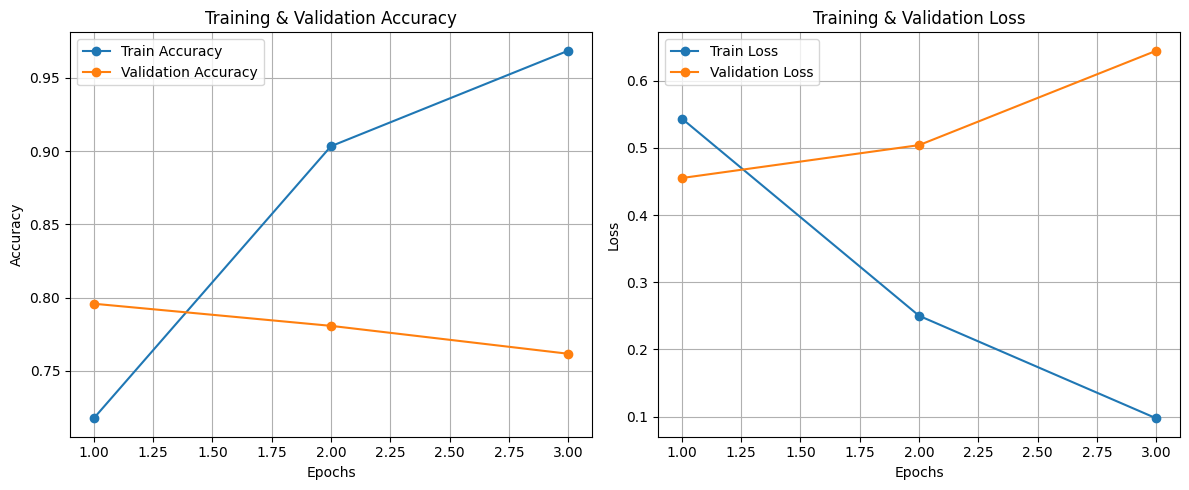

RegularizedDenseModel


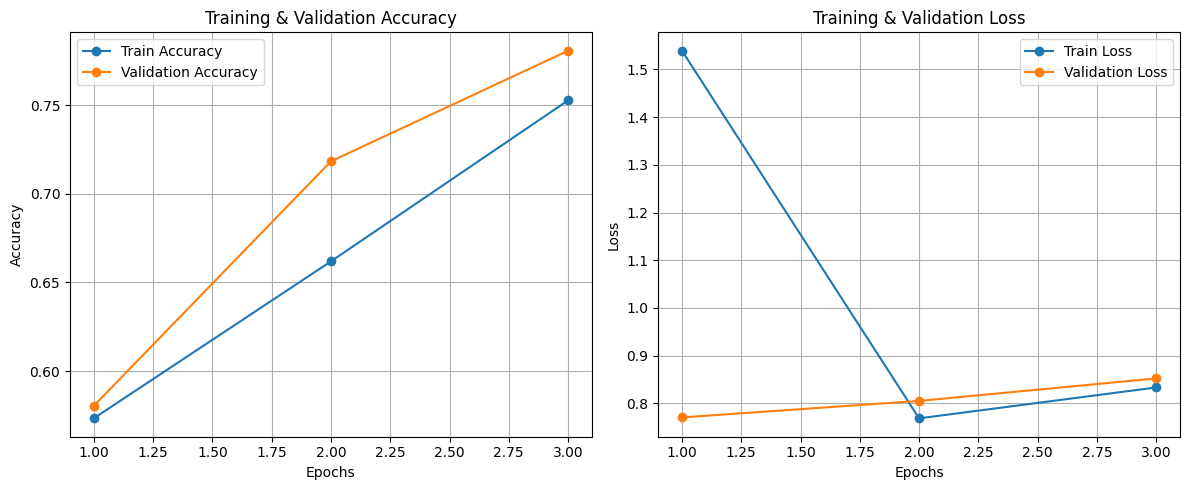

RegularizedDropoutDenseModel


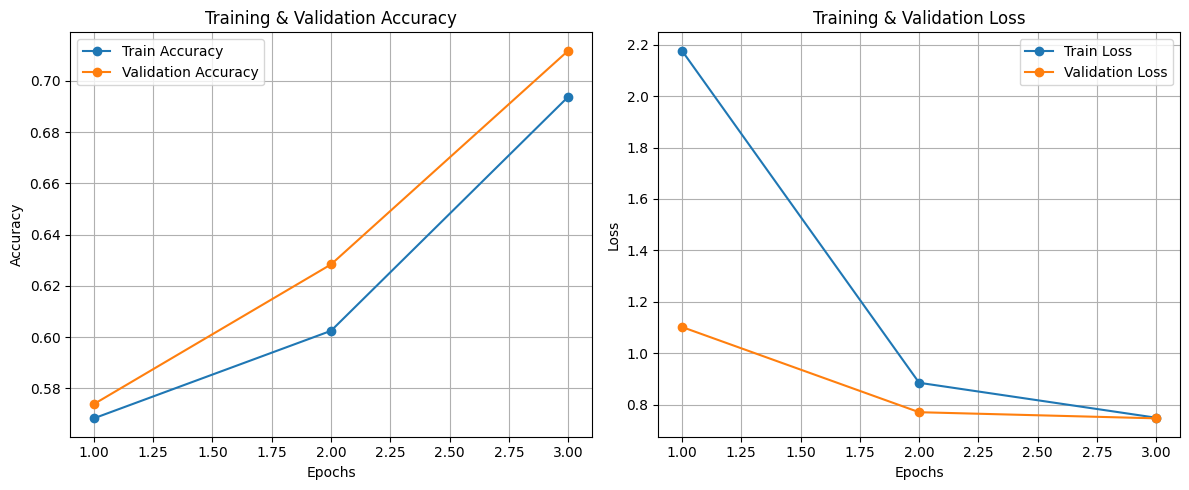

ModerateDeepDenseModel


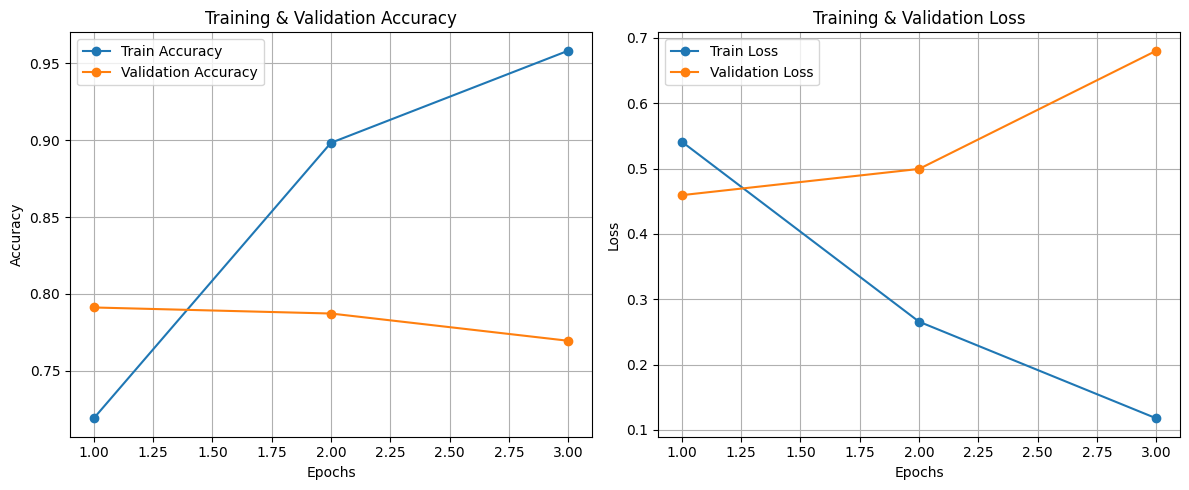

DeepDenseModel


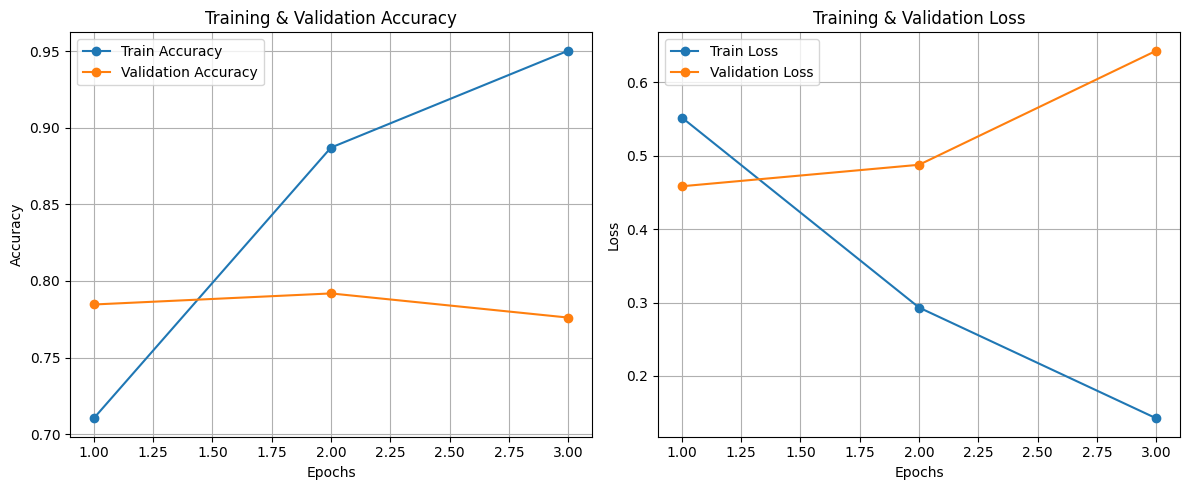

CNNModel


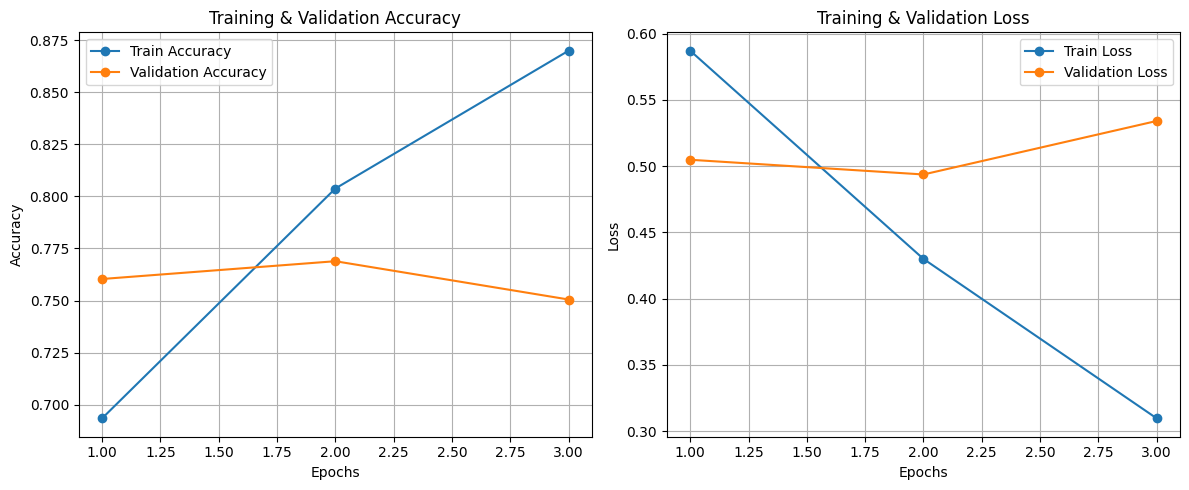

LSTMModel


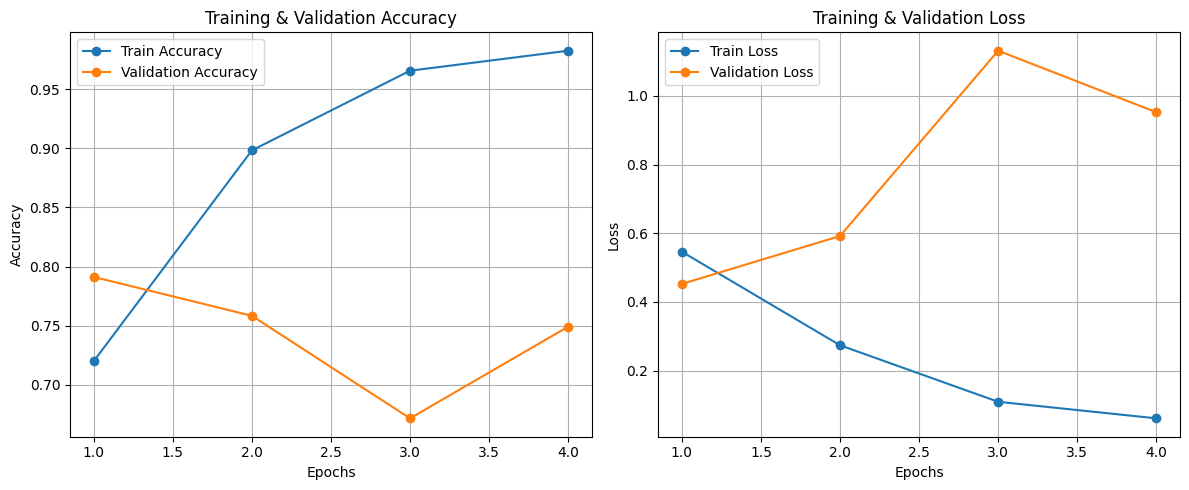

In [25]:
for model_name, result in results.items():
    print(model_name)
    history = result["history"]
    epochs = range(1, len(history["accuracy"]) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(epochs, history["accuracy"], label="Train Accuracy", marker="o")
    ax[0].plot(epochs, history["val_accuracy"], label="Validation Accuracy", marker="o")
    ax[0].set_title("Training & Validation Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot(epochs, history["loss"], label="Train Loss", marker="o")
    ax[1].plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    ax[1].set_title("Training & Validation Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    ax[1].grid(True)
    plt.tight_layout()
    plt.show()

<ipython-input-26-bf9c1f310e98>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(model_results_linear.keys(), rotation=15)


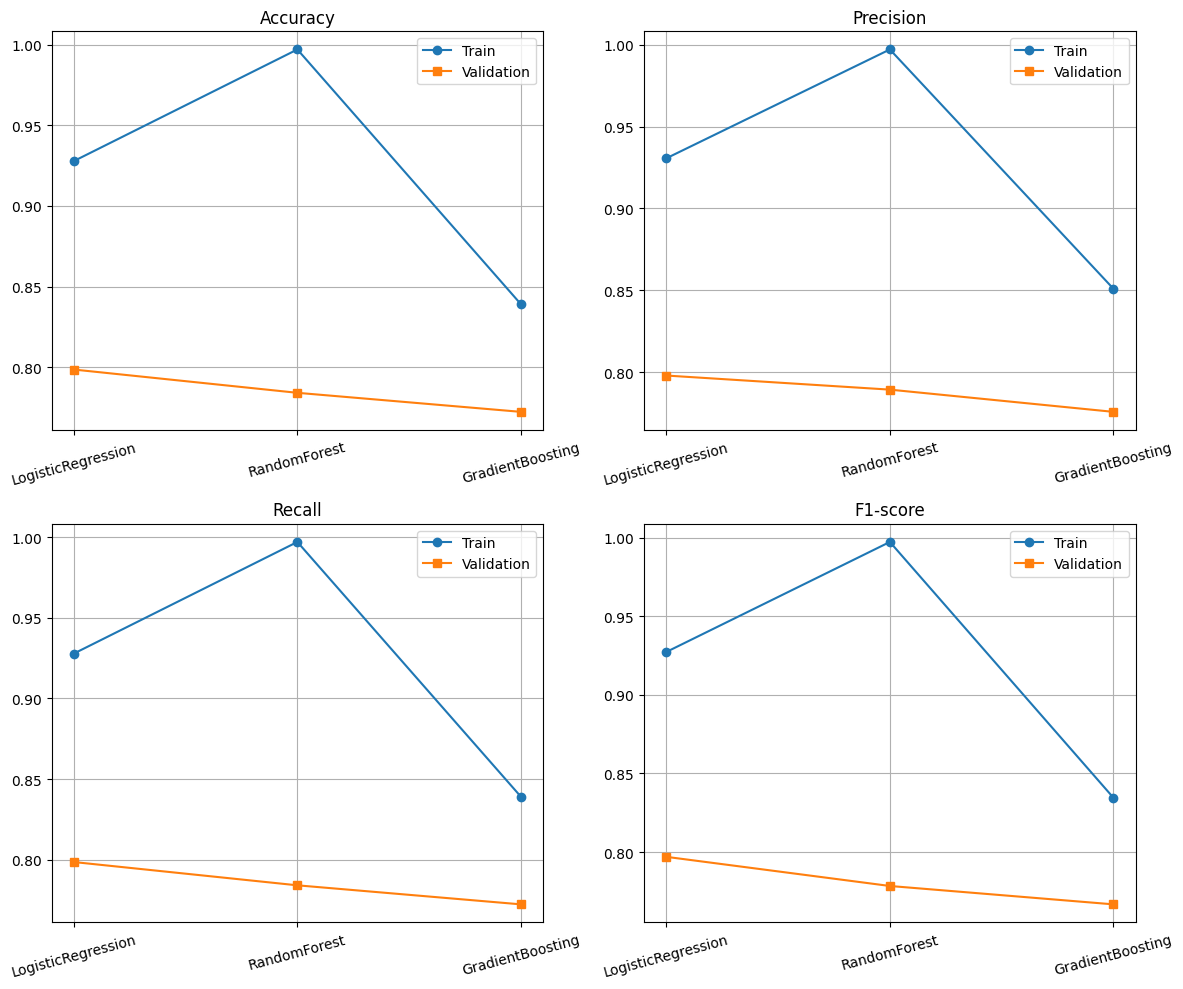

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
metric_pairs = [("train_accuracy", "val_accuracy"), ("train_precision", "val_precision"),
                ("train_recall", "val_recall"), ("train_f1", "val_f1")]
titles = ["Accuracy", "Precision", "Recall", "F1-score"]
axes = ax.ravel()

for i, (train_metric, val_metric) in enumerate(metric_pairs):
    axes[i].plot(model_results_linear.keys(), [result[train_metric] for result in model_results_linear.values()], 
                 marker='o', label='Train')
    axes[i].plot(model_results_linear.keys(), [result[val_metric] for result in model_results_linear.values()], 
                 marker='s', label='Validation')
    axes[i].set_title(titles[i])
    axes[i].set_xticklabels(model_results_linear.keys(), rotation=15)
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()

# Conclusion

Overall I was happy with the results in terms of their accuracy. 79.4% is well above random chance. For this specific problem it felt like using hypertuning along with LogisticRegression, RandomForest, and GradientBoost was a bit unnecessary given all the result metrics were the same and the processing time was excessive. A lesson learned was not starting with a lot of hyperparams and instead adding to them as necessary. 

The neural net models with drop out and regularization did exactly as expected and helped smooth out accuracy plots. I think in the future I would also look to tune the learning rates and batch sizes more. The LSTM model (78.8%) and Logistic Regression (79.4%) had very comparable results which was a bit frustrating. In the future I would place more of an emphasis on what pre-processing steps to take along with when and how to use which form of vectorization. 